# Using Convolutional Neural Networks

Welcome to the first week of the first deep learning certificate! We're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning.

## Introduction to this week's task: 'Dogs vs Cats'

We're going to try to create a model to enter the [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats) competition at Kaggle. There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): *"**State of the art**: The current literature suggests machine classifiers can score above 80% accuracy on this task"*. So if we can beat 80%, then we will be at the cutting edge as of 2013!

## Basic setup

There isn't too much to do to get started - just a few simple configuration steps.

This imports all dependencies and shows plots in the web page itself - we always wants to use this when using jupyter notebook:

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.utils.trainer as trainer
import torch.utils.trainer.plugins
from torch.autograd import Variable
import numpy as np
import os

from torchsample.modules import ModuleTrainer
from torchsample.metrics import CategoricalAccuracy

%matplotlib inline

In [3]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

Define path to data: (It's a good idea to put it in a subdirectory of your notebooks folder, and then exclude that directory from git control by adding it to .gitignore.). Additionaly set use_cuda = True to use a GPU for training and prediction.

In [11]:
data_path = "data/dogscats/"
# data_path = "data/dogscats/sample/"
use_cuda = True
batch_size = 64
print('Using CUDA:', use_cuda)

Using CUDA: False


# Use a pretrained VGG model with PyTorch's **Vgg16** class

Our first step is simply to use a model that has been fully created for us, which can recognise a wide variety (1,000 categories) of images. We will use 'VGG', which won the 2014 Imagenet competition, and is a very simple model to create and understand. The VGG Imagenet team created both a larger, slower, slightly more accurate model (*VGG  19*) and a smaller, faster model (*VGG 16*). We will be using VGG 16 since the much slower performance of VGG19 is generally not worth the very minor improvement in accuracy.

PyTorch includes a class, *Vgg16*, which makes using the VGG 16 model very straightforward. 

## The punchline: state of the art custom model in 7 lines of code

Here's everything you need to do to get >97% accuracy on the Dogs vs Cats dataset - we won't analyze how it works behind the scenes yet, since at this stage we're just going to focus on the minimum necessary to actually do useful work.

In [5]:
# TODO refactor the code below and put it in utils.py to simplify allow creating a custom model in 7 lines of code

## Use Vgg16 for basic image recognition

Let's start off by using the *Vgg16* class to recognise the main imagenet category for each image.

We won't be able to enter the Cats vs Dogs competition with an Imagenet model alone, since 'cat' and 'dog' are not categories in Imagenet - instead each individual breed is a separate category. However, we can use it to see how well it can recognise the images, which is a good first step.

First create a DataLoader which will read the images from disk, resize them, convert them into tensors and normalize them the same way the Vgg16 network was trained (using ImageNet's RGB mean and std).

In [12]:
# Data loading code
traindir = os.path.join(data_path, 'train')
valdir = os.path.join(data_path, 'valid') 
# cd data/dogscats && mkdir -p test && mv test1 test/
testdir = os.path.join(data_path, 'test')

# pytorch way of implementing fastai's get_batches, (utils.py)
def get_data_loader(dirname, shuffle=True, batch_size = 64):
    # pytorch's VGG requires images to be 224x224 and normalized using https://github.com/pytorch/vision#models
    normalize = transforms.Compose([
        transforms.Lambda(lambda img: img.resize((224, 224), Image.BILINEAR)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    image_folder = datasets.ImageFolder(dirname, normalize)
    return torch.utils.data.DataLoader(image_folder, batch_size=batch_size, 
                                       shuffle=shuffle, pin_memory=use_cuda), image_folder

train_loader, folder = get_data_loader(traindir, batch_size=batch_size)
val_loader, folder = get_data_loader(valdir, shuffle=False, batch_size=batch_size)
test_loader, testfolder = get_data_loader(testdir, shuffle=False, batch_size=batch_size)

print('Images in test folder:', len(testfolder.imgs))

Images in test folder: 6


Then, create a Vgg16 object:

In [13]:
# Load the model
model = models.vgg16(pretrained=True)

Then *finetune* the model such that it will be trained based on the data in the batches provided - in this case, to predict either 'dog' or 'cat'.

In [22]:
# Finetune by replacing the last fully connected layer and freezing all network parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully-connected layer matching the new class count
classes = train_loader.dataset.classes
num_classes = len(classes)
print('Using {:d} classes: {}'.format(num_classes, classes))
model.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

# Monkey patch the parameters() to return trainable weights only
import types

def parameters(self):
    p = filter(lambda p: p.requires_grad, nn.Module.parameters(self))
    return p

model.parameters = types.MethodType(parameters, model)

Using 2 classes: ['cats', 'dogs']


In [23]:
# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss()
# enable cuda if available
if(use_cuda):
    model.cuda()
    criterion.cuda()

In [24]:
def getTrainer(lr):
    trainer = ModuleTrainer(model)
    trainer.set_optimizer(optim.Adam, lr=1e-3)
    trainer.set_loss(criterion)
    trainer.set_metrics([CategoricalAccuracy()])
    
    return trainer

Finally, we fit() the parameters of the model using the training data, reporting the accuracy on the validation set after every epoch. (An epoch is one full pass through the training data.)

In [25]:
trainer = getTrainer()
trainer.fit_loader(train_loader, val_loader=train_loader, nb_epoch=3)
# This gets a validation accuracy of 98.9 when using the whole dataset

Epoch 1/2: 4 batches [08:03, 114.11s/ batches, val_acc=50.31, val_loss=15.9782, loss=15.0138, acc=50.62]
Epoch 2/2: 4 batches [10:48, 161.16s/ batches, val_acc=61.56, val_loss=1.3137, loss=8.2031, acc=64.38]


That shows all of the steps involved in using the Vgg16 class to create an image recognition model using whatever labels you are interested in. For instance, this process could classify paintings by style, or leaves by type of disease, or satellite photos by type of crop, and so forth.
Next up, we'll dig one level deeper to see what's going on in the Vgg16 class.

## Visually validate the classifier

In [19]:
# Define some helper functions

def denorm(tensor):
    # Undo the image normalization + clamp between 0 and 1 to avoid image artifacts
    for t, m, s in zip(tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]): 
        t.mul_(s).add_(m).clamp_(0, 1)
    return tensor

def get_images_to_plot(images_tensor):
    denormalize = transforms.Compose([
        transforms.Lambda(denorm)
    ])
    return denormalize(images_tensor)

def get_classes_strings(classes, labels_ids):
    # returns the classes in string format
    return [classes[label_id] for label_id in labels_ids]

def get_prediction_classes_ids(predictions):
    # returns the predictions in id format
    predictions_ids = predictions.cpu().data.numpy().argmax(1)
    return predictions_ids

def get_prediction_classes_strings(classes, predictions):
    # returns the predictions in string format
    return get_classes_strings(classes, get_prediction_classes_ids(predictions))

['cats', 'dogs', 'cats', 'dogs']


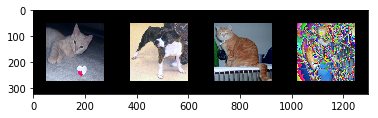

In [30]:
# display a sample set of images and their labels
loader, folder = get_data_loader(valdir, batch_size = 4)
images, labels = next(iter(loader))
show(make_grid(get_images_to_plot(images), padding=100))
labels_string = get_classes_strings(classes, labels.numpy())
print(labels_string)

In [31]:
# display the predictons for the images above
if use_cuda:
    images = images.cuda()
predictions = model(Variable(images))
predictions_string = get_prediction_classes_strings(classes, predictions)
print(predictions_string)

['cats', 'dogs', 'cats', 'dogs']
